# Run David Feldman's NGS/PEAR analysis script and analyze results

### Imports

In [1]:
%load_ext lab_black
import pandas as pd
import random
import numpy as np
import pickle
from glob import glob
import os
import re
import math
from operator import itemgetter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
def save_obj(obj, name):
    with open(name + ".pkl", "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name + ".pkl", "rb") as f:
        return pickle.load(f)

### Get subpools

In [3]:
pool_paths = glob(
    "/home/pleung/projects/peptide_binders/r0/peptide_binders/05_to_order/final_sequences_pool_*.tab*"
)

pool_paths = sorted(pool_paths, key=lambda x: int(x.split("_")[-1][:-4]))

In [4]:
output_path = os.path.join(os.getcwd(), "06_analyze_sequencing")
os.makedirs(output_path, exist_ok=True)

with open(os.path.join(output_path, "designs.csv"), "w") as designs_csv:
    designs_csv.write("subpool,design_name,insert_dna\n")
    for path in pool_paths:
        subpool = path.split("_")[-1].replace(".tab", "")
        with open(path, "r") as subpool_file:
            for line in subpool_file:
                design_name = line.split(" ")[0]
                insert_dna = line.split(" ")[1]
                designs_csv.write(f"subpool_{subpool},{design_name},{insert_dna}")

In [5]:
runs = glob("/net/scratch/pleung/miseq/fastq/*R1*")

In [6]:
with open("/net/scratch/pleung/miseq/samples.csv", "w") as file:
    file.write("sample,fastq_name,adapter_5,adapter_3\n")
    for run in runs:
        sample_name = run.split("/")[-1].split("_L001_")[0]
        file.write(
            f"{sample_name},{sample_name},GGGTCGGCTTCGCATATG,CTCGAGGGTGGAGGTTCC\n"
        )  # petcon

### Get final scores

In [7]:
scores_df = pd.read_json(
    "/home/pleung/projects/peptide_binders/r0/peptide_binders/04_run_af2_short/to_order.json"
)
scores_df.head()

,bb_clash,binder_blocked_sap,buns_heavy_ball_1.1D,chA_length,chA_seq,closure_type,contact_molec_sq5_ap_target,contact_molec_sq5_apap_target,contact_molecular_surface,contact_molecular_surface_ap_target,...,plddt_model_4,rmsd_model_4,plddt_model_3,rmsd_model_3,plddt_model_5,rmsd_model_5,plddt_model_1,rmsd_model_1,plddt_model_2,rmsd_model_2
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_c279cc011884489bb3bd87955711e41d.pdb.bz2,51.110954,20.521736,3,148,SLEEEVEELAREIEKTLPNTELAKMAQRLAEEAIKSTNEDQLQAVR...,loop_match,4220.148926,4102.687988,470.965515,274.956177,...,89.571575,4.070545,93.395208,0.831378,92.553989,0.862758,89.635359,3.885080,92.612467,0.777808
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_4fd3e8f585ce4214a1fe1bdd630d5225.pdb.bz2,50.605976,16.504375,2,162,DERLRKVAEKARRAAQEGNKEAVKEQLETALQIAEEIGTQEAYIRA...,strict_remodel,5752.316406,5754.550293,553.563354,372.134888,...,90.712871,1.539361,92.418350,1.377122,92.900396,1.305535,93.257176,1.301201,92.541632,1.689770
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_a9abc7c0229446ae8e3346f7740f3266.pdb.bz2,51.110954,12.571028,0,148,SSREEVQRLAEEIEKRLPNTELAKKAKELAHEALRSNNEEVLEAVR...,loop_match,5274.601074,5112.895508,548.668335,314.615936,...,89.444139,3.573369,95.862795,1.181407,95.025084,1.112146,87.941999,3.090777,93.706381,1.069208
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_d0d42fc423e9477fbe29b918e545e5d6.pdb.bz2,51.110954,15.610469,0,148,SSEEEVRELAERIKEELPNTELARTAEQLAKEAMKSDDERVLEAVR...,loop_match,5049.398926,4841.844727,475.207642,296.474823,...,94.803017,0.826303,95.225922,0.870984,95.248136,0.968500,90.773068,1.244015,95.191234,0.882711
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0000/2021.08.04.09.17.34.501637_1573d0ac4e014147827d0c01ef8e17c6.pdb.bz2,51.823433,18.749239,1,162,DRELHEVAERARQAAREGNREEVRRQLQTALEIAKRIGTEQAFEIA...,strict_remodel,4776.076660,4622.958984,624.580750,345.242279,...,88.512658,3.147834,91.886557,3.460839,90.639611,3.337857,89.930644,1.418606,89.510235,1.561189


### Get mapping of results csvs to what sort it was

In [8]:
def row2results_csv(row: pd.Series) -> str:
    sample_id = row.name
    sample_name = row["Sample_Name"]
    results_csv = (
        f"/net/scratch/pleung/miseq/results/{sample_name}_S{str(sample_id)}.matched.csv"
    )

    return results_csv


mapping_df = pd.read_csv("/net/scratch/pleung/miseq/SampleSheet.csv")
mapping_df.columns = mapping_df.iloc[24]
mapping_df = mapping_df.iloc[26:33]
mapping_df.set_index("Sample_ID", inplace=True)
mapping_df["results_csv"] = mapping_df.progress_apply(row2results_csv, axis=1)
mapping_df.set_index("results_csv", inplace=True)

mapping = dict(mapping_df["Sample_Plate"])
mapping = {v.split("_")[0]: k for k, v in mapping.items()}
mapping

  0%|          | 0/7 [00:00<?, ?it/s]

{'GLP1': '/net/scratch/pleung/miseq/results/560075_S1.matched.csv',
 'GIP': '/net/scratch/pleung/miseq/results/560076_S2.matched.csv',
 'PTH': '/net/scratch/pleung/miseq/results/560077_S3.matched.csv',
 'NPY': '/net/scratch/pleung/miseq/results/560078_S4.matched.csv',
 'Glucagon': '/net/scratch/pleung/miseq/results/560079_S5.matched.csv',
 'Naive': '/net/scratch/pleung/miseq/results/560080_S6.matched.csv',
 'Expression': '/net/scratch/pleung/miseq/results/560081_S7.matched.csv'}

In [9]:
mapping_dfs = {}
for k, v in tqdm(mapping.items()):
    sort_df = pd.read_csv(v)
    sort_df.set_index("design_name", inplace=True)
    mapping_dfs[k] = sort_df

  0%|          | 0/7 [00:00<?, ?it/s]

### Determine whether designs in the final df transformed, expressed, and see if they bound to any targets

In [10]:
def row2seq_counts(row: pd.Series, sort_key: str) -> int:
    design = row.name
    count = 0
    if design in mapping_dfs[sort_key].index:
        count = mapping_dfs[sort_key].loc[design]["count"]
        if type(count) == np.int64:
            count = int(count)
        else:  # multiple DNA sequences aligned to the same design?
            count = int(sum(count))
    else:
        pass
    return count

In [11]:
scores_df["count_transformed"] = scores_df.progress_apply(
    row2seq_counts, sort_key="Naive", axis=1
)

  0%|          | 0/17618 [00:00<?, ?it/s]

In [12]:
scores_df["count_expressed"] = scores_df.progress_apply(
    row2seq_counts, sort_key="Expression", axis=1
)

  0%|          | 0/17618 [00:00<?, ?it/s]

In [13]:
scores_df["count_GLP1"] = scores_df.progress_apply(
    row2seq_counts, sort_key="GLP1", axis=1
)
scores_df["count_GIP"] = scores_df.progress_apply(
    row2seq_counts, sort_key="GIP", axis=1
)
scores_df["count_PTH"] = scores_df.progress_apply(
    row2seq_counts, sort_key="PTH", axis=1
)
scores_df["count_NPY"] = scores_df.progress_apply(
    row2seq_counts, sort_key="NPY", axis=1
)
scores_df["count_Glucagon"] = scores_df.progress_apply(
    row2seq_counts, sort_key="Glucagon", axis=1
)

  0%|          | 0/17618 [00:00<?, ?it/s]

  0%|          | 0/17618 [00:00<?, ?it/s]

  0%|          | 0/17618 [00:00<?, ?it/s]

  0%|          | 0/17618 [00:00<?, ?it/s]

  0%|          | 0/17618 [00:00<?, ?it/s]

In [14]:
for col in [c for c in scores_df.columns if "count_" in c]:
    q = f"{col} > 0"
    print(f"{col}: {len(scores_df.query(q))}")

count_transformed: 4621
count_expressed: 4516
count_GLP1: 488
count_GIP: 276
count_PTH: 1250
count_NPY: 2280
count_Glucagon: 2275


### Determine if binding was on target

In [15]:
name_mapping = {
    "apoe": "APOE",
    "covstem": "COVSTEM",
    "gip": "GIP",
    "glp": "GLP1",
    "glucagon": "Glucagon",
    "neuropeptideY": "NPY",
    "pth": "PTH",
}

scores_df["count_APOE"] = 0
scores_df["count_COVSTEM"] = 0


def row2on_target_ratio(row: pd.Series) -> float:
    if row["count_expressed"] == 0:
        return 0.0
    else:
        target = name_mapping[row["target_name"]]
        on_target = row[f"count_{target}"]
        off_targets = [
            f"count_{k}"
            for k, _ in mapping.items()
            if (k != "Naive" and k != "Expression" and k != on_target)
        ]
        off_target = sum(row[off_targets])
        if on_target == 0:
            return 0.0
        elif off_target == 0:
            return 1.0
        else:
            return on_target / off_target


scores_df["on_target_ratio"] = scores_df.progress_apply(row2on_target_ratio, axis=1)

  0%|          | 0/17618 [00:00<?, ?it/s]

In [16]:
expressed_df = scores_df.query("count_expressed > 0")

bound_df = expressed_df.query(
    "count_GLP1 > 0 or count_GIP > 0 or count_NPY > 0 or count_PTH > 0 or count_Glucagon > 0"
)
len(bound_df)

2515

### Setup for plotting

In [17]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

In [18]:
list(bound_df.columns)

['bb_clash',
 'binder_blocked_sap',
 'buns_heavy_ball_1.1D',
 'chA_length',
 'chA_seq',
 'closure_type',
 'contact_molec_sq5_ap_target',
 'contact_molec_sq5_apap_target',
 'contact_molecular_surface',
 'contact_molecular_surface_ap_target',
 'contact_molecular_surface_apap_target',
 'contact_patch',
 'ddg',
 'ddg_hydrophobic',
 'disulfide_at',
 'docked_helix',
 'dslf_fa13',
 'fa_atr',
 'fa_atr_pocket',
 'fa_dun_dev',
 'fa_dun_rot',
 'fa_dun_semi',
 'fa_elec',
 'fa_intra_atr_xover4',
 'fa_intra_elec',
 'fa_intra_rep_xover4',
 'fa_intra_sol_xover4',
 'fa_rep',
 'fa_sol',
 'hbond_bb_sc',
 'hbond_lr_bb',
 'hbond_sc',
 'hbond_sr_bb',
 'hxl_tors',
 'hydrophobic_residue_contacts',
 'interface_buried_sasa',
 'interface_hydrophobic_count',
 'interface_hydrophobics',
 'interface_polar_count',
 'lk_ball',
 'lk_ball_bridge',
 'lk_ball_bridge_uncpl',
 'lk_ball_iso',
 'new_loop_resis',
 'omega',
 'p_aa_pp',
 'parent',
 'parent_length',
 'pivot_helix',
 'pre_break_helix',
 'prefix',
 'pro_close',
 'r

### For sequences that had some amount of on-target binding, how did that correllate with counts of different targets

<Figure size 2304x2304 with 0 Axes>

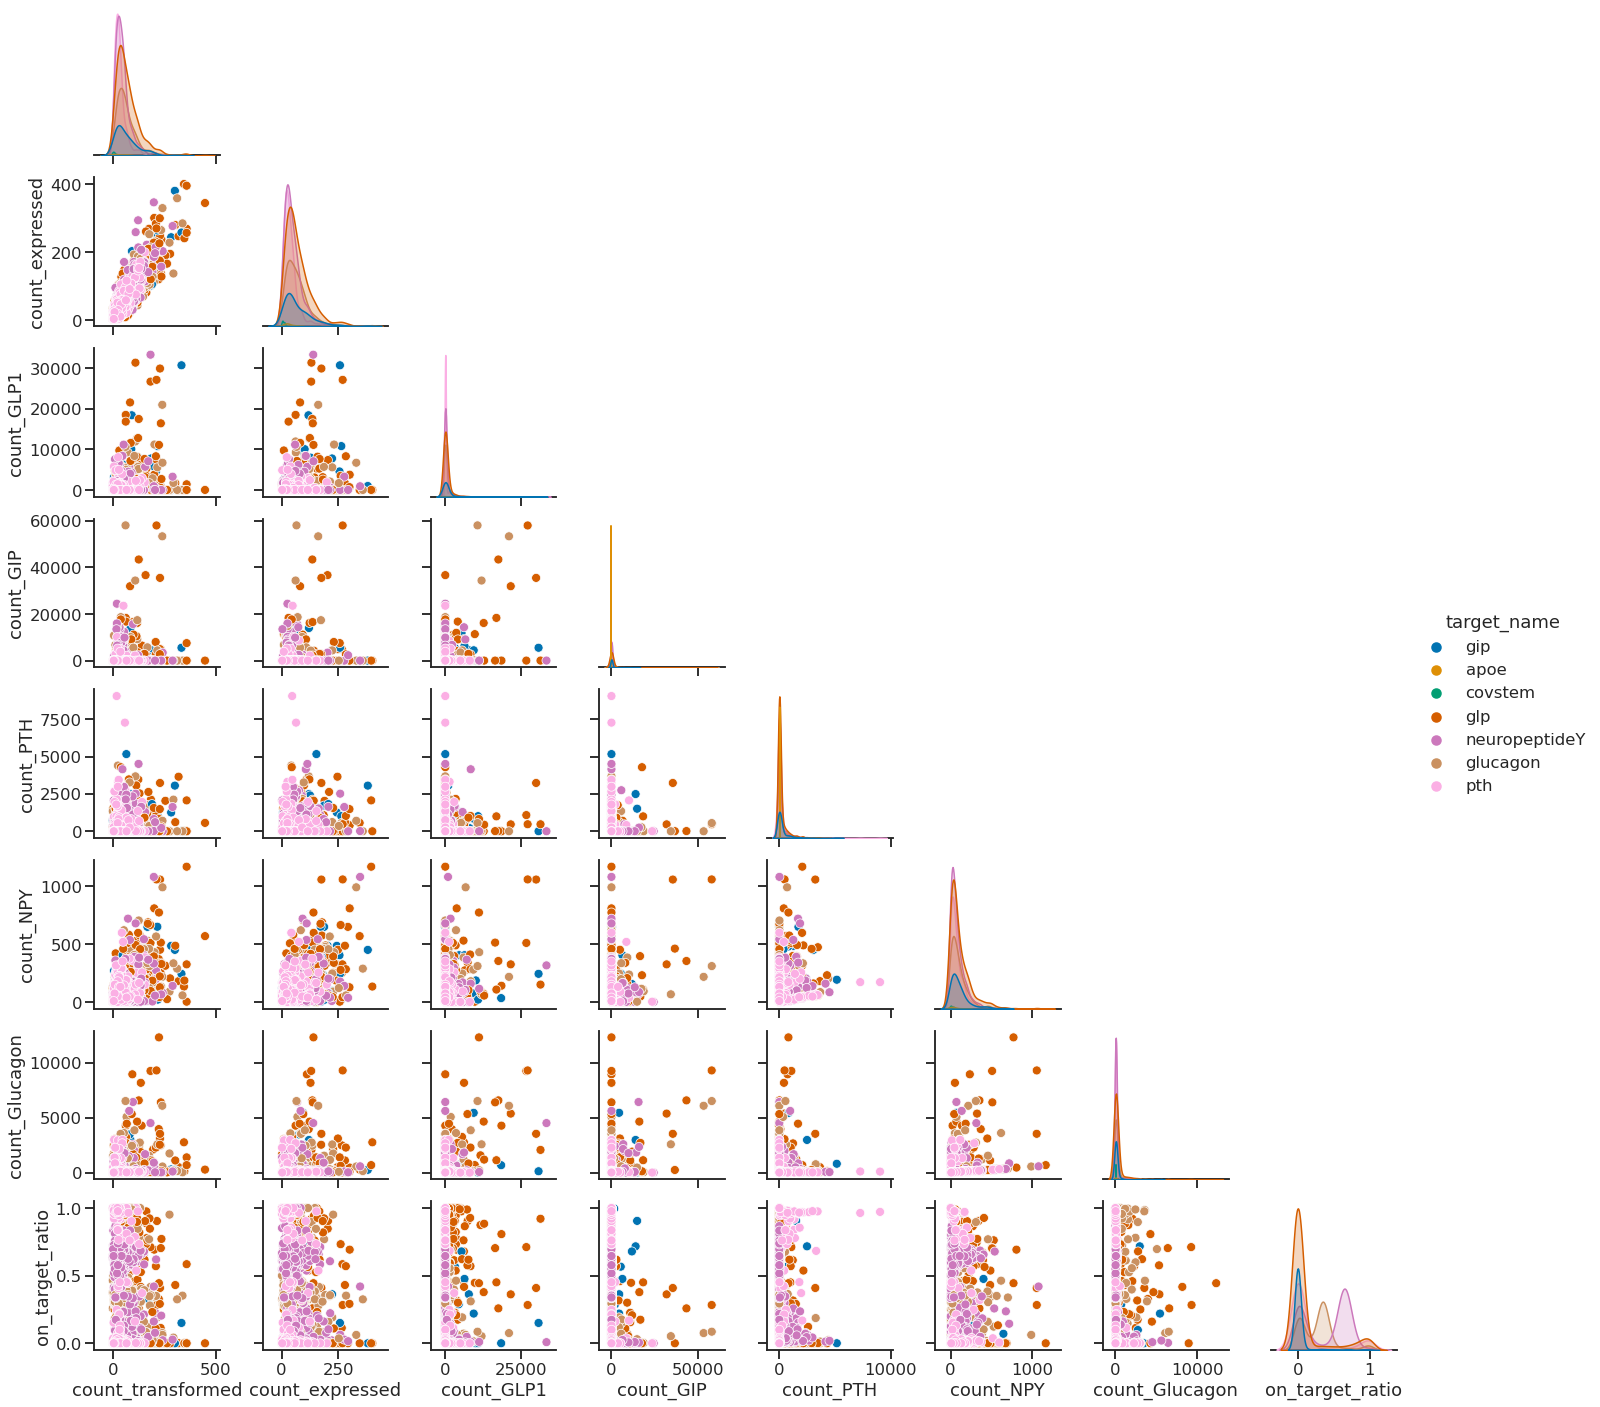

In [19]:
import sys

sys.path.insert(0, "/projects/crispy_shifty")

from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    c
    for c in bound_df.columns
    if "count_" in c and "APOE" not in c and "COVSTEM" not in c
] + ["on_target_ratio"]

the_fig = pairplot_df(
    df=bound_df,
    cols=cols,
    hue="target_name",
)
plt.savefig(
    os.path.join(os.getcwd(), "06_analyze_sequencing", "counts_vs_on_target.png")
)

<Figure size 2304x2304 with 0 Axes>

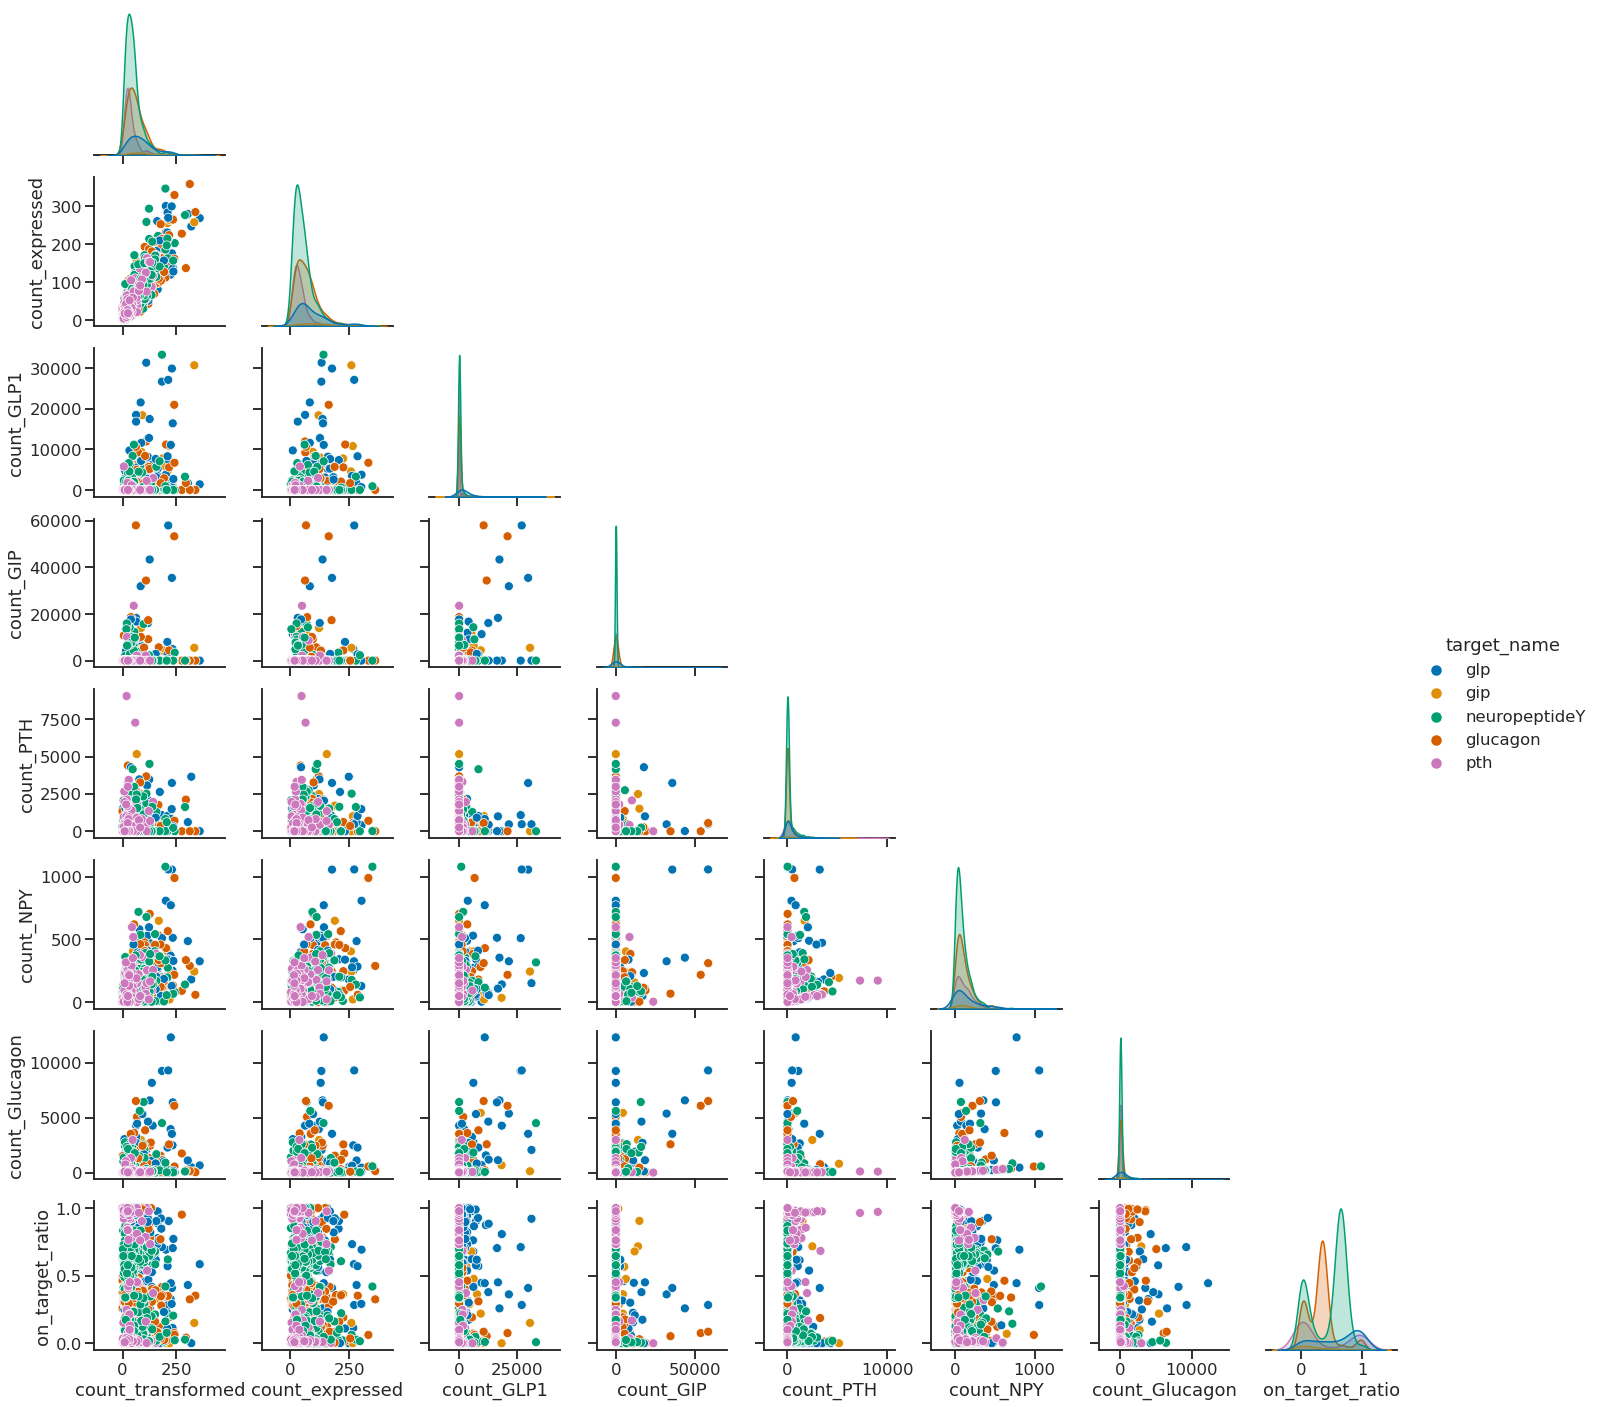

In [20]:
on_target_df = bound_df.query("on_target_ratio > 0")

the_fig = pairplot_df(
    df=on_target_df,
    cols=cols,
    hue="target_name",
)
plt.savefig(
    os.path.join(
        os.getcwd(), "06_analyze_sequencing", "counts_vs_on_target_nonzero.png"
    )
)

<Figure size 2304x2304 with 0 Axes>

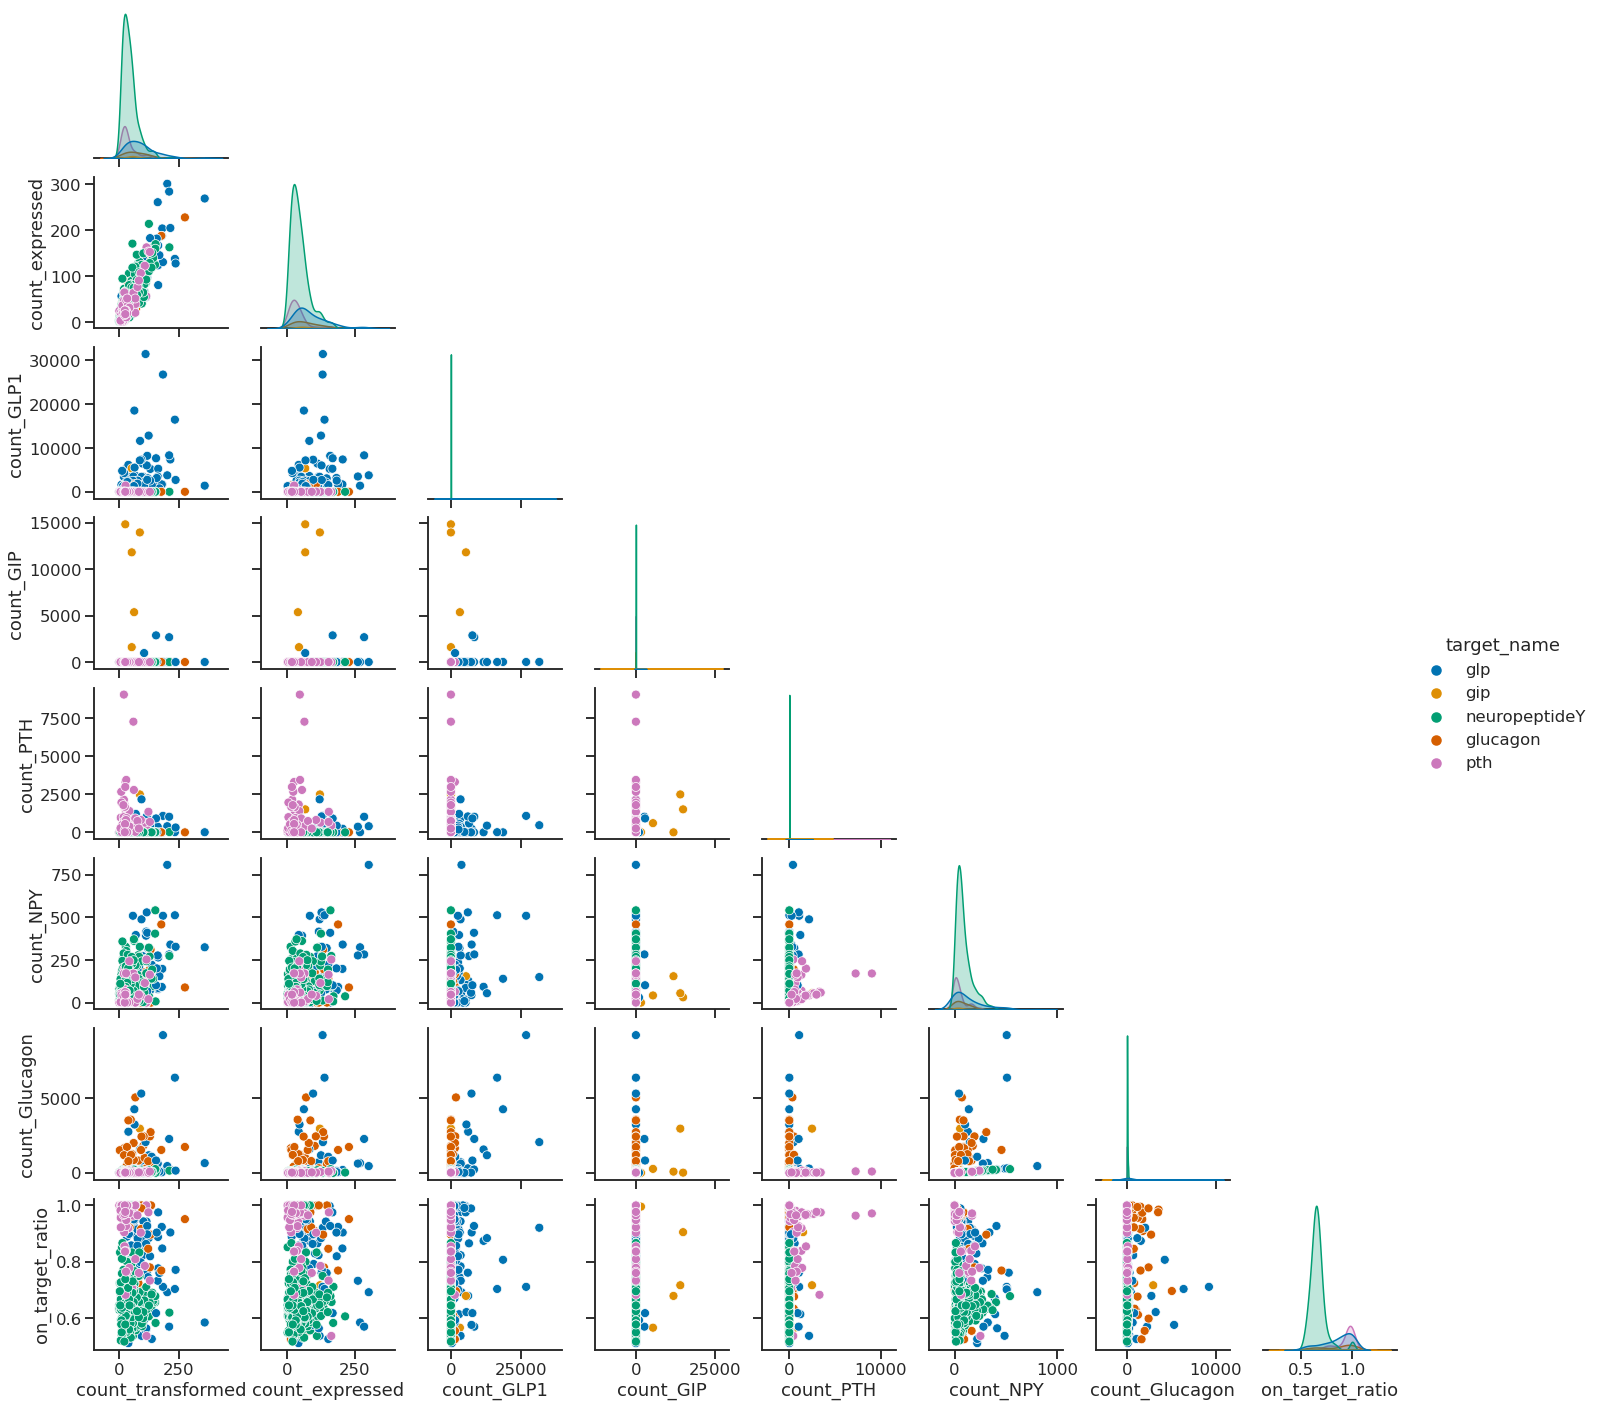

In [21]:
specific_df = bound_df.query("on_target_ratio > 0.5")

the_fig = pairplot_df(
    df=specific_df,
    cols=cols,
    hue="target_name",
)
plt.savefig(
    os.path.join(
        os.getcwd(), "06_analyze_sequencing", "counts_vs_on_target_specific.png"
    )
)

### Make individual figures for nonzero, on target counts

In [23]:
hue_order = ["glp", "gip", "neuropeptideY", "glucagon", "pth"]

for target in mapping.keys():
    if target == "Expression" or target == "Naive":
        continue
    else:
        pass
    query = f"on_target_ratio > 0.5 and count_{target} > 100"
    specific_df = bound_df.query(query)
    fig = plt.figure(figsize=(10, 10))
    the_fig = sns.scatterplot(
        x=f"count_{target}",
        y="on_target_ratio",
        data=specific_df,
        hue="target_name",
        hue_order=hue_order,
    )
    fig.tight_layout()
    print(specific_df.loc[specific_df[f"count_{target}"].idxmax()])

    plt.savefig(
        os.path.join(
            os.getcwd(),
            "06_analyze_sequencing",
            f"only_{target}_counts_vs_on_target_specific.png",
        )
    )
    plt.close()

bb_clash                                                        51.110954
binder_blocked_sap                                              16.890051
buns_heavy_ball_1.1D                                                    1
chA_length                                                            148
chA_seq                 SQREKVRELAQEIHKQLPDTELAQKAQELAHEAARSDNEEVLEAVR...
                                              ...                        
count_NPY                                                             150
count_Glucagon                                                       2064
count_APOE                                                              0
count_COVSTEM                                                           0
on_target_ratio                                                  0.920807
Name: /mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/04_cleanup_short/decoys/0013/2021.08.04.09.17.34.501637_78f90f2c55834e07aa53ba06a268c56b.pdb.bz2, Length: 93, dtype: ob

### Make list to try predict complex

In [24]:
to_predict = []

for target in mapping.keys():
    if target == "Expression" or target == "Naive":
        continue
    else:
        pass
    query = f"on_target_ratio > 0.5 and count_{target} > 10"
    specific_df = bound_df.query(query)
    to_predict.extend(list(specific_df.index))

with open(
    os.path.join(
        os.getcwd(),
        "06_analyze_sequencing",
        "to_predict.list",
    ),
    "w",
) as f:
    for p in to_predict:
        print(p, file=f)

### Make list to do cleanup with MPNN

In [28]:
to_redesign = []

inverse_name_mapping = {v: k for k, v in name_mapping.items()}

for target in mapping.keys():
    if target == "Expression" or target == "Naive":
        continue
    else:
        pass
    query = f"on_target_ratio > 0.6 and count_{target} > 100 and target_name == '{inverse_name_mapping[target]}'"
    specific_df = bound_df.query(query)
    to_redesign.extend(list(specific_df.index))

with open(
    os.path.join(
        os.getcwd(),
        "06_analyze_sequencing",
        "to_redesign.list",
    ),
    "w",
) as f:
    for p in to_redesign:
        print(p, file=f)